## Lab 3: Inference Attacks on Deep Neural Networks

In [1]:
import tensorflow as tf
import numpy as np
import os

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Parameters
learning_rate = 0.001
training_epochs = 20
batch_size = 100
display_step = 1

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
# tf Graph Input
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes

# Set model weights
W1 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b1 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))

W3 = tf.Variable(tf.zeros([300, 10]))
b3 = tf.Variable(tf.zeros([10]))

#y_pred = tf.Variable(np.arange(3000), dtype=tf.float32, name="prediction")

# Construct model

hidden1 = tf.nn.relu(tf.matmul(x, W1) + b1); #first hidden layer

#hidden2 = tf.nn.relu(tf.matmul(hidden1, W2) + b2); #second hidden layer

# Modified Logits

pred = tf.nn.softmax(tf.matmul(hidden1, W3) + b3) # Softmax layer outputs prediction probabilities

# Minimize error using cross entropy 
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

saver = tf.train.Saver()  

In [3]:
# Start training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
            
#             print(__w)
            
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
#             print(sess.run(W))
            print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print ("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy for 3000 examples; you should get roughly ~90% accuracy although it might vary from run to run
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print ("Accuracy:", 
           accuracy.eval({x: mnist.test.images[:3000], 
                          y: mnist.test.labels[:3000]},
                         session=sess))
    
    #Save the model
    saver.save(sess, './temp/trained_model.ckpt')
    print("Model saved!")

Epoch: 0001 cost= 0.568671353
Epoch: 0002 cost= 0.373144725
Epoch: 0003 cost= 0.336067680
Epoch: 0004 cost= 0.314319142
Epoch: 0005 cost= 0.299973846
Epoch: 0006 cost= 0.289477005
Epoch: 0007 cost= 0.281256828
Epoch: 0008 cost= 0.274212296
Epoch: 0009 cost= 0.268631754
Epoch: 0010 cost= 0.263763844
Epoch: 0011 cost= 0.259624370
Epoch: 0012 cost= 0.255736650
Epoch: 0013 cost= 0.252128850
Epoch: 0014 cost= 0.249415753
Epoch: 0015 cost= 0.246759809
Epoch: 0016 cost= 0.244208927
Epoch: 0017 cost= 0.242266400
Epoch: 0018 cost= 0.239676933
Epoch: 0019 cost= 0.238200037
Epoch: 0020 cost= 0.236517065
Optimization Finished!
Accuracy: 0.900333
Model saved!


## Put data into variables

In [4]:
xtr = mnist.train.images
ytr = mnist.train.labels

xts = mnist.test.images
yts = mnist.test.labels

## Help functions used to generate y(label) and x(initial image)

y is generated by label.

x can be selected from 'random', 'allmean' and 'classmean' to satisfied requirements of Q1-Q3. Argument l indicates the label, only used by Q3.

In [5]:
def generate_y(i):
    y_gen = np.zeros(10)
    y_gen[i]= 1
    return y_gen

def generate_x(l, img_type):
    
    if img_type == 'random':
        gen_image = np.random.uniform(0,255,(28,28))
        gen_image = gen_image/255
        
    elif img_type == 'allmean':
        gen_image = np.mean(xtr, axis=0)
        gen_image = gen_image.reshape(28,28)
    
    elif img_type == 'classmean':
        gen_image = xtr[ytr[:,l]==[1]]
        gen_image  = np.mean(gen_image, axis=0)
        gen_image = gen_image.reshape(28,28)
    
    else:
        print('Cant Find Correct Image!')
    
    return gen_image

## Use euclidean distances to find closest picture in training set.

RMSE = sqrt((euclidean_distance)^2/n) <- n=784

return rmse value & the closest image

In [6]:
from scipy.spatial.distance import cdist
from math import sqrt

def smallest_rmse(image_new):
    image_new = image_new.reshape(1,784) 

    distance = cdist(xtr,image_new,'euclidean')

    closest_ind = np.argmin(distance)
    closest_dis = distance[closest_ind]
    rmse = sqrt((closest_dis)**2/784)

    closest_img = xtr[closest_ind]
    closest_img = closest_img.reshape(28,28)
    
    return rmse, closest_img   

## Function to optimized and update the image.

### Iteration stops when the probability of image being classified as a selected label i no longer increases.

In [7]:
def image_optimizer(image_old, i, lr, print_=True):
    # Initial value of probabilities
    prob_old = np.zeros((1,10))
    prob_new = np.zeros((1,10))
    prob_new[:,i] = 1   
    
    # Initial image = image_old
    image = np.reshape(image_old,(1,784))
    
    # Adaptive step size
    step_size = lr
    
    # Iteration number count
    n = 0
    
    # Iteration for optimize
    if (prob_new[:,i]-prob_old[:,i]>= 1e-8):
        
        gradient = tf.gradients(xs = x, ys = cost)
        image_new = tf.clip_by_value(x - tf.fill([784], step_size)/gradient,0,1)
        image_new, gradient = sess.run([image_new , gradient], feed_dict={x: image, y: generate_y(j).reshape(1,10)})
        image_new = image_new[0,:,:]
        image = image_new
        
        # Update stepsize and iteration counts
        n = n+1
        
    image_old1 = image_old.reshape(1,784) 
    prob_old = pred
    prob_old = prob_old.eval({x: image_old1})    

    prediction_old = tf.argmax(pred,1)
    prediction_old = prediction_old.eval({x: image_old1})    

    prob_new = pred
    prob_new = prob_new.eval({x: image_new})

    prediction_new = tf.argmax(pred,1)
    prediction_new = prediction_new.eval({x: image_new})    
     
    if print_ == True:
        print( 'Label: ', str(i),
              '   Iteration count: ',n,
              '\nInitial prediction: ', str(prediction_old),
              '   Final prediction: ',str(prediction_new),
              '\nInitial probablity of target label: ', str(prob_old[:,j]),
              '   Final probablity of target label: ', str((prob_new[:,j])))
    else:
        return image_new

    return image_new

## Help functins to evaluate the result

plot_image: plot closest image for each label

result_eva: print mean rmse and plot closest images

In [8]:
def plot_image(images):
    plt.figure(1)
    for i in range(10):
        image_plot = images[i]
        image_reshape = image_plot.reshape((28,28))

        plt.subplot(1,10,i+1)
        plt.title(str(i))
        plt.imshow(image_reshape, cmap='gray', interpolation='nearest')
        plt.axis('off')
    plt.show() 
    
def result_eva(rmse_by_label, image_nearest, image_recovered):
    
    rmse_by_label_float = [ '%.2f' % elem for elem in rmse_by_label ]
    print('Image recovered for each label: ')
    plot_image(image_recovered)   
    
    print('RMSE for each recovered image:')
    print(rmse_by_label_float)
    
    print('\nFinal error: ', np.mean(rmse_by_label))

## 1.	AM with Random Initialization:

In [9]:
import pylab as plt
import os

image_nearest = []
rmse_by_label = []
image_recovered = []

# Start training
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    if os.path.exists('temp/checkpoint'): 
        saver.restore(sess, 'temp/trained_model.ckpt')

    for j in range(10):
        
        # Generate a new random picture
        image_old = generate_x(1, 'random')
        
        # Optimaze by gradient descent
        image_opt = image_optimizer(image_old,j,1e-1, True)
        
        # Calculate rmse and find nearst image in training set
        image_rmsei, image_closesti = smallest_rmse(image_opt)
        
        # Save rmse, nearst image, and recovered image
        image_recovered.append(image_opt)
        image_nearest.append(image_closesti)
        rmse_by_label.append(image_rmsei)
        print()
    
    print('Optimize Finished!')

INFO:tensorflow:Restoring parameters from temp/trained_model.ckpt
Label:  0    Iteration count:  1 
Initial prediction:  [3]    Final prediction:  [0] 
Initial probablity of target label:  [ 0.0007834]    Final probablity of target label:  [ 0.99882609]

Label:  1    Iteration count:  1 
Initial prediction:  [2]    Final prediction:  [1] 
Initial probablity of target label:  [  4.17752249e-10]    Final probablity of target label:  [ 0.99334514]

Label:  2    Iteration count:  1 
Initial prediction:  [3]    Final prediction:  [2] 
Initial probablity of target label:  [ 0.15266232]    Final probablity of target label:  [ 1.]

Label:  3    Iteration count:  1 
Initial prediction:  [2]    Final prediction:  [3] 
Initial probablity of target label:  [ 0.33448961]    Final probablity of target label:  [ 1.]

Label:  4    Iteration count:  1 
Initial prediction:  [2]    Final prediction:  [4] 
Initial probablity of target label:  [  5.64237688e-08]    Final probablity of target label:  [ 0.99

Image recovered for each label: 


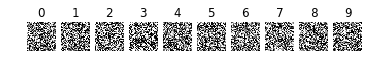

RMSE for each recovered image:
['0.58', '0.58', '0.59', '0.61', '0.57', '0.58', '0.58', '0.60', '0.57', '0.57']

Final error:  0.584037576869


In [10]:
result_eva(rmse_by_label, image_nearest, image_recovered)

## 2.	AM with Mean Initialization

In [11]:
image_nearest = []
image_recovered = []
rmse_by_label = []

# Start training
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    if os.path.exists('temp/checkpoint'): 
        saver.restore(sess, 'temp/trained_model.ckpt')
        
    # Generate init image that is the average over all training data images
    image_old = generate_x(1, 'allmean')
    
    for j in range(10):
        
        # Optimaze by gradient descent
        image_opt = image_optimizer(image_old,j,1e-2, True)
        
        # Calculate rmse and find nearst image in training set
        image_rmsei, image_closesti = smallest_rmse(image_opt)
        
        # Save rmse and nearst image
        image_recovered.append(image_opt)
        image_nearest.append(image_closesti)
        rmse_by_label.append(image_rmsei)
        print()
    
    print('Optimize Finished!')

INFO:tensorflow:Restoring parameters from temp/trained_model.ckpt
Label:  0    Iteration count:  1 
Initial prediction:  [8]    Final prediction:  [0] 
Initial probablity of target label:  [ 0.01130814]    Final probablity of target label:  [ 0.56989694]

Label:  1    Iteration count:  1 
Initial prediction:  [8]    Final prediction:  [3] 
Initial probablity of target label:  [ 0.00069976]    Final probablity of target label:  [ 0.01623382]

Label:  2    Iteration count:  1 
Initial prediction:  [8]    Final prediction:  [2] 
Initial probablity of target label:  [ 0.07801374]    Final probablity of target label:  [ 0.84295166]

Label:  3    Iteration count:  1 
Initial prediction:  [8]    Final prediction:  [3] 
Initial probablity of target label:  [ 0.18045723]    Final probablity of target label:  [ 0.81753194]

Label:  4    Iteration count:  1 
Initial prediction:  [8]    Final prediction:  [4] 
Initial probablity of target label:  [ 0.01391096]    Final probablity of target label: 

Initial image using all mean:


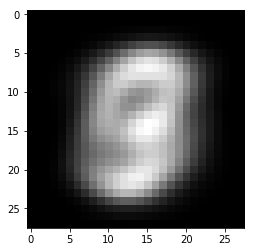

Image recovered for each label: 


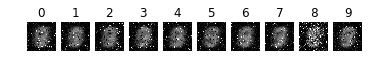

RMSE for each recovered image:
['0.24', '0.23', '0.25', '0.24', '0.23', '0.23', '0.23', '0.23', '0.31', '0.24']

Final error:  0.242795698032


In [12]:
print('Initial image using all mean:')
image_old = generate_x(1, 'allmean')
image_old = image_old.reshape(28,28) 
plt.imshow(image_old, cmap='gray')
plt.show()   

result_eva(rmse_by_label, image_nearest, image_recovered)

## 3.	AM with Per-Class Mean Initialization

In [13]:
image_nearest = []
image_init = []
image_recovered = []
rmse_by_label = []

# Start training
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    if os.path.exists('temp/checkpoint'): 
        saver.restore(sess, 'temp/trained_model.ckpt')
        

    for j in range(10):
       
        # Generate init image that is the average over all training data images has the same label of target
        image_old = generate_x(j, 'classmean')
        image_init.append(image_old)
                               
        # Optimaze by gradient descent
        image_opt = image_optimizer(image_old,j, 1e-5, True)
        
        # Calculate rmse and find nearst image in training set
        image_rmsei, image_closesti = smallest_rmse(image_opt)
        
        # Save rmse and nearst image
        image_recovered.append(image_opt)
        image_nearest.append(image_closesti)
        rmse_by_label.append(image_rmsei)
        print()
    
    print('Optimize Finished!')

INFO:tensorflow:Restoring parameters from temp/trained_model.ckpt
Label:  0    Iteration count:  1 
Initial prediction:  [0]    Final prediction:  [0] 
Initial probablity of target label:  [ 0.99961686]    Final probablity of target label:  [ 1.]

Label:  1    Iteration count:  1 
Initial prediction:  [1]    Final prediction:  [1] 
Initial probablity of target label:  [ 0.93955612]    Final probablity of target label:  [ 0.94517261]

Label:  2    Iteration count:  1 
Initial prediction:  [2]    Final prediction:  [2] 
Initial probablity of target label:  [ 0.98297161]    Final probablity of target label:  [ 0.98643076]

Label:  3    Iteration count:  1 
Initial prediction:  [3]    Final prediction:  [3] 
Initial probablity of target label:  [ 0.99081039]    Final probablity of target label:  [ 0.99486595]

Label:  4    Iteration count:  1 
Initial prediction:  [4]    Final prediction:  [4] 
Initial probablity of target label:  [ 0.94692236]    Final probablity of target label:  [ 0.958

Initial image for each class:


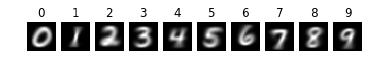

Image recovered for each label: 


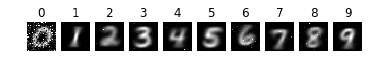

RMSE for each recovered image:
['0.30', '0.11', '0.20', '0.17', '0.17', '0.18', '0.17', '0.15', '0.18', '0.16']

Final error:  0.180048482053


In [14]:
print('Initial image for each class:')
plot_image(image_init)
result_eva(rmse_by_label, image_nearest, image_recovered)

## 4.	Differentially Private Training

In [15]:
import os

scales = [0.01,0.1,0.5,1]
acc = []

lamboda_w1 = []
lamboda_w3 = []

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    if os.path.exists('temp/checkpoint'): 
        saver.restore(sess, 'temp/trained_model.ckpt')  
        
    w3 = np.array(W3.eval())
    
    for n, scale in enumerate(scales):
        noise_W1 = np.random.laplace(loc=0, scale=scale, size=(784,300))
        
        std_W3 = np.std(w3)
        noise_W3 = np.random.laplace(loc=0, scale=scale*std_W3, size=(300,10))
        
        sess.run(tf.assign(W1, W1 + noise_W1))
        sess.run(tf.assign(W3, W3 + noise_W3))
        
        lamboda_w1.append(scale)
        lamboda_w3.append(scale*std_W3)
    
    # Test model
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        # Calculate accuracy for 3000 examples; you should get roughly ~90% accuracy although it might vary from run to run
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        acci = accuracy.eval({x: mnist.test.images[:3000], 
                              y: mnist.test.labels[:3000]},
                             session=sess)
        
        acc.append(acci)
        
        # Print Results
        print ("Lambda:", 
               scale,
               "Accuracy:", 
              acci)
        
        model_name = './temp/new_model_'+str(n)+'.ckpt'
            
        #Save the model
        saver.save(sess, model_name)
        print("Model named " + model_name+" saved!\n")

INFO:tensorflow:Restoring parameters from temp/trained_model.ckpt
Lambda: 0.01 Accuracy: 0.901
Model named ./temp/new_model_0.ckpt saved!

Lambda: 0.1 Accuracy: 0.893667
Model named ./temp/new_model_1.ckpt saved!

Lambda: 0.5 Accuracy: 0.59
Model named ./temp/new_model_2.ckpt saved!

Lambda: 1 Accuracy: 0.265
Model named ./temp/new_model_3.ckpt saved!



In [16]:
# Start training
rmse_by_lambda = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for n, scale in enumerate(scales):

        image_nearest = []
        image_init = []
        image_recovered = []
        rmse_by_label = []
        
        #Load the saved model
        if os.path.exists('temp/checkpoint'): 
            name = './temp/new_model_'+str(n)+'.ckpt'
            saver.restore(sess, name)
            
            # AM attack
            for j in range(10):

                # Generate init image that is the average over all training data images has the same label of target
                image_old = generate_x(j, 'classmean')
                image_init.append(image_old)

                # Optimaze by gradient descent
                image_opt = image_optimizer(image_old,j, 1e-5, False)

                # Calculate rmse and find nearst image in training set
                image_rmsei, image_closesti = smallest_rmse(image_opt)

                # Save rmse and nearst image
                image_recovered.append(image_opt)
                image_nearest.append(image_closesti)
                rmse_by_label.append(image_rmsei)
        
        rmse_by_lambda.append(np.mean(rmse_by_label))
        print('Optimize Finished for alpha: ', scale)

INFO:tensorflow:Restoring parameters from ./temp/new_model_0.ckpt
Optimize Finished for alpha:  0.01
INFO:tensorflow:Restoring parameters from ./temp/new_model_1.ckpt
Optimize Finished for alpha:  0.1
INFO:tensorflow:Restoring parameters from ./temp/new_model_2.ckpt
Optimize Finished for alpha:  0.5
INFO:tensorflow:Restoring parameters from ./temp/new_model_3.ckpt
Optimize Finished for alpha:  1


Showing the result in table.

In [17]:
import pandas as pd

d = {'W1 Lambda': lamboda_w1,
    'W3 Lambda': lamboda_w3,
    'Accuracy': acc,
     'RMSE': rmse_by_lambda}
df = pd.DataFrame(data=d)
df.index = scales
df.index.name = 'Alpha'

df.head()

,Accuracy,RMSE,W1 Lambda,W3 Lambda
Alpha,,,,
0.01,0.901000,0.183190,0.01,0.000275
0.10,0.893667,0.186217,0.10,0.002748
0.50,0.590000,0.168544,0.50,0.013741
1.00,0.265000,0.169029,1.00,0.027482
